In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

In [2]:
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [65]:
def fold_change_acrossBRs(data, itp):
    """Compute fold change to initial time point in every BR.
    Note that data should always be a list, even if just one BR."""
    new = []
    for i, mat in enumerate(data):
        new.append(TimePointFoldChange(mat, itp))
    return new

def TimePointFoldChange(d, itp):
    """ Take fold-change of the time lapse data set to an initial time point  """
    for jj in range(1, d.columns.size):
        d.iloc[:, jj] /= d[d["Elapsed"] == itp].iloc[0, jj]
    return d

def transform_DRviability(data, units, itp, survival_plot=True):
    """Transform to initial time point and convert into seaborn format"""
    new = fold_change_acrossBRs(data, itp)
    c = pd.concat(data, axis=0)
    c = pd.melt(c, id_vars="Elapsed", value_vars=c.columns[1:], var_name="Lines", value_name="% Survival (FC Control)")
    c["Condition"] = [s.split(" ")[1].split(" ")[0] for s in c["Lines"]]
    c["Inh_concentration"] = [s[4:].split(" ")[1] for s in c["Lines"]]
    c["Lines"] = [s.split(" ")[0] for s in c["Lines"]]
    c = c[["Elapsed", "Lines", "Condition", "Inh_concentration", "% Survival (FC Control)"]]
    c = c[c["Elapsed"] >= itp]
    c.insert(0, "IC_n", [float(s.split(units)[0]) for s in c["Inh_concentration"]])

    if survival_plot:
        cls = []
        for line in list(set(c["Lines"])):
            l_ut = c[(c["Lines"] == "WT") & (c["Condition"] == "UT") & (c["Inh_concentration"] == "0" + units)].sort_values(by="Elapsed")
            l = c[c["Lines"] == line]
            l.index = np.arange(l.shape[0])
            for treatment in list(set(l["Condition"])):
                for conc in list(set(l["Inh_concentration"])):
                    curr_idx = l[(l["Condition"] == treatment) & (l["Inh_concentration"] == conc)].sort_values(by="Elapsed").index
                    l.iloc[curr_idx, -1] /= l_ut.iloc[:, -1].values
                    l.iloc[curr_idx, -1] *= 100
            cls.append(l)
        return pd.concat(cls).sort_values(by="IC_n").drop("IC_n", axis=1)
    
    else:
        return c.sort_values(by="IC_n").drop("IC_n", axis=1)

def merge_TRs(filename, nTRs):
    """Merge technical replicates of an experiment"""
    path = "msresist/data/Validations/CellGrowth/"
    inh = pd.read_csv(path + filename)
    for i in range(1, nTRs):
        inh.columns = [col.split("." + str(i))[0].strip() for col in inh.columns]
    inh = inh.groupby(lambda x: x, axis=1).mean()
    return inh

def plot_InhDR_timepoint(ax, inhibitor, time, cl="WT", itp=24, out=False, survival_plot=True):
    """Plot inhibitor DR at specified time point."""
    if inhibitor == "Dasatinib":
        inh = [merge_TRs("Dasatinib_Dose_BR3.csv", 2), merge_TRs("Dasatinib_2fixed.csv", 2)]
        units = "nM"
    elif inhibitor == "CX-4945":
        inh = [merge_TRs("CX_4945_BR1_dose.csv", 2), merge_TRs("02032022-CX_4945_BR3_dose.csv", 2)]
        units = "uM"
    elif inhibitor == "Volasertib":
        inh = [merge_TRs("Volasertib_Dose_BR1.csv", 2), merge_TRs("Volasertib_Dose_BR2.csv", 2)]
        units = "nM"
    data = transform_DRviability(inh, units, itp, survival_plot=survival_plot)
    if out:
        return data
    tp = data[data["Elapsed"] == time]
    tp = tp[tp["Lines"] == cl]
    sns.lineplot(data=tp, x="Inh_concentration", y="% Survival (FC Control)", hue="Condition", errorbar=('ci', 68), ax=ax)
    ax.set_xlabel("[" + inhibitor + "]")

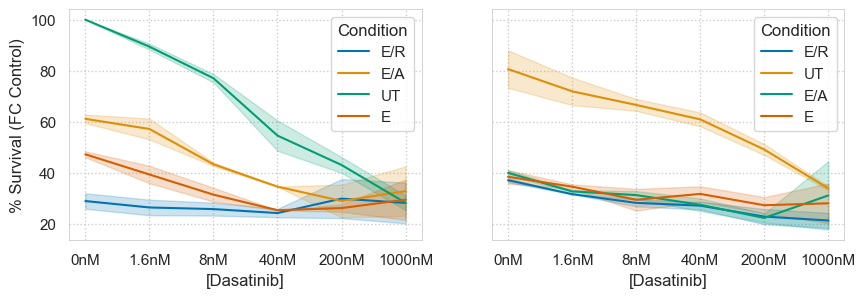

In [66]:
_, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
plot_InhDR_timepoint(ax[0], "Dasatinib", 72, cl="WT", itp=24)
plot_InhDR_timepoint(ax[1], "Dasatinib", 72, cl="KO", itp=24)

<AxesSubplot: xlabel='Elapsed', ylabel='% Survival (FC Control)'>

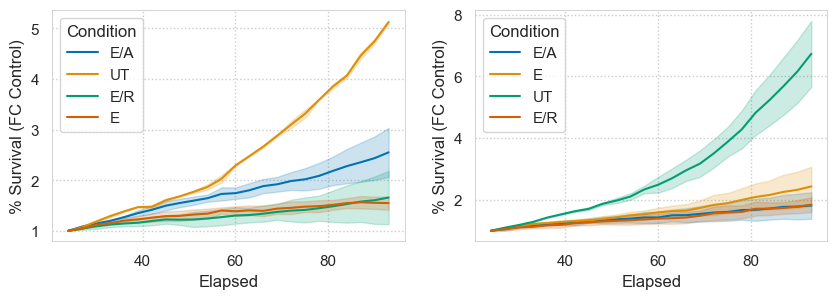

In [94]:
out_das = plot_InhDR_timepoint(ax[1], "Dasatinib", 96, cl="KO", itp=24, out=True, survival_plot=False)
d200 = out_das[(out_das["Inh_concentration"] == "40nM") & (out_das["Elapsed"] < 96)]

_, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=False)
sns.lineplot(d200[d200["Lines"] == "WT"], x="Elapsed", y="% Survival (FC Control)", hue="Condition", errorbar=('ci', 63), ax=ax[0])
sns.lineplot(d200[d200["Lines"] == "KO"], x="Elapsed", y="% Survival (FC Control)", hue="Condition", errorbar=('ci', 63), ax=ax[1])

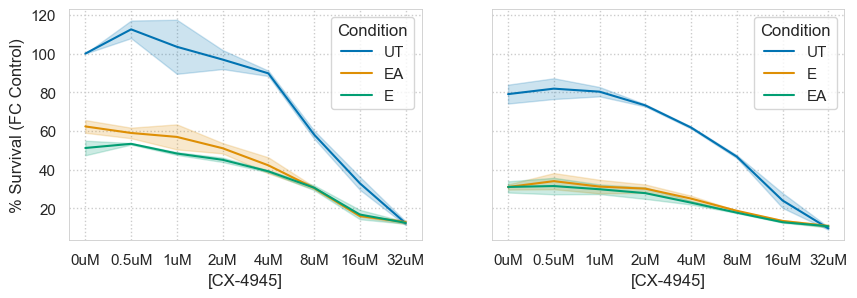

In [15]:
 _, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
phlot_InhDR_timepoint(ax[0], "CX-4945", 72, cl="WT", itp=12)
plot_InhDR_timepoint(ax[1], "CX-4945", 72, cl="KO", itp=12)

<AxesSubplot: xlabel='Elapsed', ylabel='% Survival (FC Control)'>

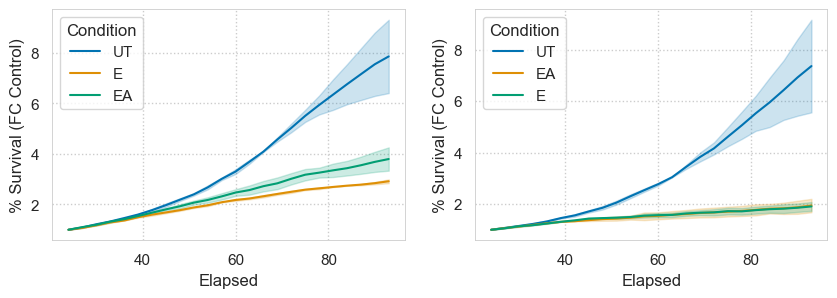

In [86]:
out_das = plot_InhDR_timepoint(ax[1], "CX-4945", 96, cl="KO", itp=24, out=True, survival_plot=False)
d200 = out_das[(out_das["Inh_concentration"] == "0uM") & (out_das["Elapsed"] < 96)]

_, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=False)
sns.lineplot(d200[d200["Lines"] == "WT"], x="Elapsed", y="% Survival (FC Control)", hue="Condition", errorbar=('ci', 68), ax=ax[0])
sns.lineplot(d200[d200["Lines"] == "KO"], x="Elapsed", y="% Survival (FC Control)", hue="Condition", errorbar=('ci', 68), ax=ax[1])

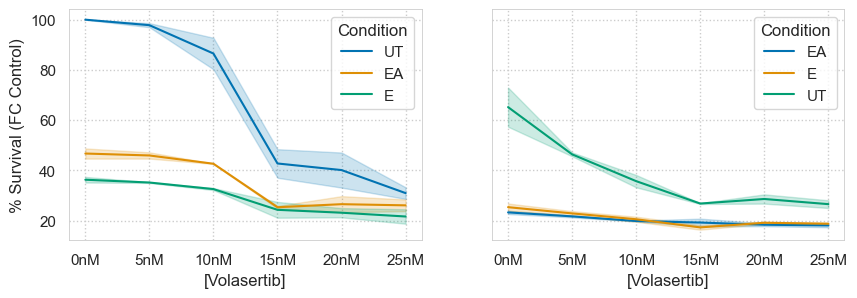

In [87]:
_, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
plot_InhDR_timepoint(ax[0], "Volasertib", 72, cl="WT", itp=21)
plot_InhDR_timepoint(ax[1], "Volasertib", 72, cl="KO", itp=21)